In [179]:
import sys, os
# from http://stackoverflow.com/questions/595305/python-path-of-script
pathname = "~/QuantAnalysis/analysis_scripts"
sys.path.append(os.path.sep.join(['..', 'analysis_utils']))
sys.path.append(os.path.sep.join(['..', 'plotting_utils']))

import ParsingUtils
import AnalysisUtils

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load simulation results

Here, we load the simulation results, loop over each simulation, and put the result into a dictionary of dataframes

In [180]:
sims = os.path.sep.join([pathname, '..', 'sims', 'rsem'])

rdict = {}
for i in xrange(1, 21):
    path = os.path.sep.join([sims, str(i)])
    print("reading results from {}".format(path))
    tdf = ParsingUtils.readRSEMTruth(os.path.sep.join([path, "truth.tsv"]) , "_true")
    kdf = ParsingUtils.readKallisto(os.path.sep.join([path, "abundance.tsv"]), "_kallisto")
    sdf = ParsingUtils.readSailfish(os.path.sep.join([path, "quant.sf"]), "_sailfish")
    df = tdf.join(kdf, rsuffix="_K").join(sdf, rsuffix="_S")
    rdict[i] = df


reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/1
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/2
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/3
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/4
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/5
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/6
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/7
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/8
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/9
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/10
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/11
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/12
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/13
reading results from ~/QuantAnalysis/analysis_scripts/../sims/rsem/14
reading results from ~/QuantA

## Compute the relative differences

For each simulation, compute the mean and median relative differences (both signed and absolute value).  Here, to avoid the effect of tiny expression values on the relative difference, we treat any TPM < 0.01 as 0.

In [210]:
relDiffs = {} 
nonZeros = {}
metricTrue = "TPM_true"
metricKallisto = "TPM_kallisto"
metricSailfish = "TPM_sailfish"
for k,v in rdict.iteritems():
    rds = AnalysisUtils.relDiff(metricTrue, metricSailfish, v, verbose=False)
    rdk = AnalysisUtils.relDiff(metricTrue, metricKallisto, v, verbose=False)
    nonZeros[k] = {'kallisto' : rdk[1], 'sailfish' : rds[1]}
    for method, rd in {"sailfish" : rds, "kallisto" : rdk}.iteritems():
        for summaryName, summaryFunc in {"median" : AnalysisUtils.getMedian, "mean" : AnalysisUtils.getMean}.iteritems(): 
            signedKey = "{}_{}_{}".format(method, summaryName, "signed")
            absKey = "{}_{}_{}".format(method, summaryName, "abs")
            if signedKey in relDiffs:
                relDiffs[signedKey].append(summaryFunc(rd[0]))
            else:
                relDiffs[signedKey] = [summaryFunc(rd[0])]
            if absKey in relDiffs:
                relDiffs[absKey].append(summaryFunc(rd[0].abs()))
            else: 
                relDiffs[absKey] = [summaryFunc(rd[0].abs())]



## Report the results

In [211]:
for signedness in ["signed", "abs"]:
    for stat in ["median", "mean"]:
        if stat == "median":
            print("mean of medians of {} relative differences is :\n kallisto: {:0.2f}\n sailfish: {:0.2f}\n".format(
                signedness, np.mean(relDiffs["kallisto_{}_{}".format(stat, signedness)]),
                np.mean(relDiffs["sailfish_{}_{}".format(stat, signedness)])))
        elif stat == "mean":
             print("median of means of {} relative differences is :\n kallisto: {:0.2f}\n sailfish: {:0.2f}\n".format(
                signedness, np.median(relDiffs["kallisto_{}_{}".format(stat, signedness)]),
                np.median(relDiffs["sailfish_{}_{}".format(stat, signedness)])))

mean of medians of signed relative differences is :
 kallisto: 0.00
 sailfish: 0.00

median of means of signed relative differences is :
 kallisto: 0.02
 sailfish: 0.02

mean of medians of abs relative differences is :
 kallisto: 0.01
 sailfish: 0.00

median of means of abs relative differences is :
 kallisto: 0.28
 sailfish: 0.28



## Now, look in a bit more detail at the first simulation

In [131]:
rdk, nz = AnalysisUtils.relDiff('TPM_true', 'TPM_kallisto', rdict[1])
rds, nz = AnalysisUtils.relDiff('TPM_true', 'TPM_sailfish', rdict[1])

Plot the (signed) relative differences for all transcripts

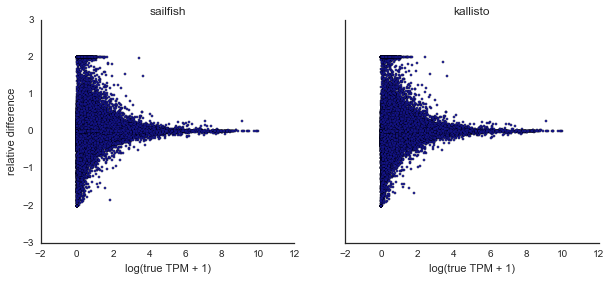

In [133]:
%matplotlib inline
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rds.values, marker='.', c=(0.1, 0.1, 0.7))
ax2.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rdk.values, marker='.', c=(0.1, 0.1, 0.7))
sns.despine()
ax1.set_xlabel('log(true TPM + 1)')
ax2.set_xlabel('log(true TPM + 1)')
ax1.set_ylabel('relative difference')
ax1.set_title('sailfish')
ax2.set_title('kallisto')
f.set_size_inches(10, 4)

Plot the (absolute) relative differences for all transcripts

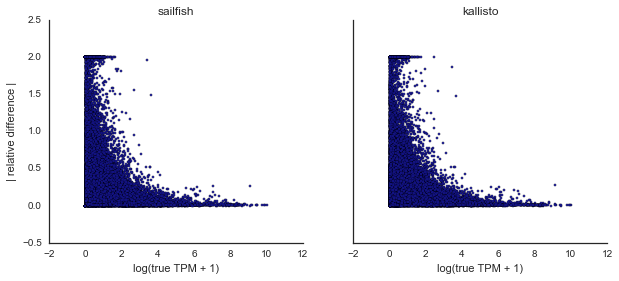

In [145]:
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rds.abs().values, marker='.', c=(0.1, 0.1, 0.7))
ax2.scatter(np.log(rdict[1]['TPM_true'].values + 1.0), rdk.abs().values, marker='.', c=(0.1, 0.1, 0.7))
sns.despine()
ax1.set_xlabel('log(true TPM + 1)')
ax2.set_xlabel('log(true TPM + 1)')
ax1.set_ylabel('| relative difference |')
ax1.set_title('sailfish')
ax2.set_title('kallisto')
f.set_size_inches(10, 4)

Finally, just take a look at the scatter plot of the actual TPMs

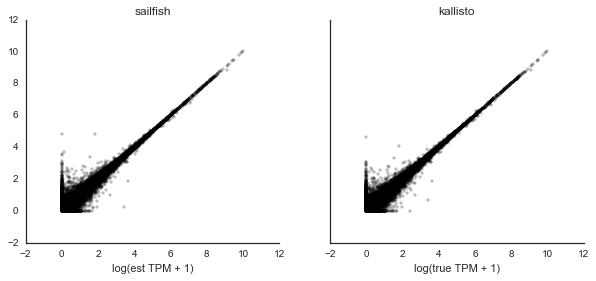

In [159]:
sns.set_style('white')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.log(rdict[1]['TPM_true']+1), np.log(rdict[1]['TPM_sailfish']+1), marker='.', c=(0.1, 0.1, 0.5, 0.01))
ax2.scatter(np.log(rdict[1]['TPM_true']+1), np.log(rdict[1]['TPM_kallisto']+1), marker='.', c=(0.1, 0.1, 0.5, 0.01))
ax1.set_xlabel('log(true TPM + 1)')
ax2.set_xlabel('log(true TPM + 1)')
ax1.set_xlabel('log(est TPM + 1)')
ax1.set_title('sailfish')
ax2.set_title('kallisto')
sns.despine()
f.set_size_inches(10, 4)